In [8]:
import pandas as pd
import numpy as np
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.utils import np_utils
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from numpy import expand_dims
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from glob import glob

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os.path
from tensorflow.keras.models import load_model

import operator
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import pylab as pl

import seaborn as sns
import matplotlib.pyplot as plt   
from IPython.display import Image, display
import matplotlib.cm as cm

import warnings
warnings.filterwarnings("ignore")

In [9]:
physical_devices = tf.config.list_physical_devices('GPU')
print('Number of GPUs: ', len(tf.config.list_physical_devices('GPU')))
tf.config.experimental.set_memory_growth(physical_devices[0],True)

Number of GPUs:  1


# Model Predictions Dataframe Initialisation


In [10]:
def open_images(paths):
    '''
    Opens a batch of images, given the image path(s) as a list
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(224,224))
        image = np.array(image)/255.0
        images.append(image)
    return np.array(images)

def get_labels(paths):
    '''
    it is possible to get the label from the path, just split the path by "/" and index -2
    For example, /kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1020.jpg
    splitting by "/" gives ['kaggle','input','brain-tumor-mri-dataset','Training','pituitary','Tr-pi_1020.jpg']
    Now indexing -2 gives "pituitary"
    '''
    label = []
    for path in paths:
        path = path.split('/')[-2]
        label.append(labels.index(path))
    return label

train_dir = r'Training/'
test_dir = r'Testing/'

train_paths = []
test_paths = []


for label in os.listdir(train_dir):
    for file in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+file)


for label in os.listdir(test_dir):
    for file in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+file)

labels_test = os.listdir(test_dir)
labels_train = os.listdir(train_dir)

model_predictions_train = pd.DataFrame(columns = ['3c2f','vgg16','vgg16_ctrained','resnet','resnet_ctrained','inception','inception_ctrained','actual'], 
                                       index = train_paths ).fillna('here')

model_predictions_test = pd.DataFrame(columns = ['3c2f','vgg16','vgg16_ctrained','resnet','resnet_ctrained','inception','inception_ctrained','actual'], 
                                       index = test_paths ).fillna('here')

## Loading Data and Augmenting Data

In [11]:
generator_train = ImageDataGenerator(rescale=1/255,
                                     rotation_range=7,
                                     horizontal_flip=True,
                                     shear_range=0.1,
                                     height_shift_range=0.07,
                                     zoom_range=0.1)


train = generator_train.flow_from_directory(r'Training', target_size=(224,224), # height and width of images to feed into CNN
                                              batch_size=16, class_mode= "categorical", color_mode='rgb')


generator_test = ImageDataGenerator(rescale=1/255,
                                     rotation_range=7,
                                     horizontal_flip=True,
                                     shear_range=0.1,
                                     height_shift_range=0.07,
                                     zoom_range=0.1)


test = generator_test.flow_from_directory(r'Testing', target_size=(224,224),
                                              batch_size=16, class_mode= "categorical", color_mode='rgb')

IMAGE_SIZE = [224, 224]

train_path = r'Training'
valid_path = r'Testing'

folders = glob(r'Training/*')

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


# Model Predictions Dataframe Initialisation

In [ ]:
model1 = Sequential()

# Convolutional layer 1
model1.add(Conv2D(filters = 32, kernel_size = (3,3), input_shape=(224, 224, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2), strides = 2))

# Convolutional layer 2
model1.add(Conv2D(64,(3,3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 3
model1.add(Conv2D(128,(3,3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Flatten())

# Feedforward
model1.add(Dense(units= 512, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(units=512, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(units=4, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.0001, clipvalue=0.5)
model1.compile(optimizer=optimizer, loss='categorical_crossentropy',
                   metrics= ['categorical_accuracy'])

model1_es = EarlyStopping(monitor = 'loss', min_delta = 1e-11, patience = 12, verbose = 1)
model1_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)
model1_mcp = ModelCheckpoint(filepath = r'temp\model1_weights.h5', monitor = 'categorical_accuracy',
                             save_best_only = True, verbose = 1)

history1 = model1.fit(train, steps_per_epoch=5712//16, epochs=120, validation_data=test, validation_steps= 1311//16, callbacks=[model1_es, model1_rlr, model1_mcp])


# Model 1


In [ ]:
model1 = Sequential()

# Convolutional layer 1
model1.add(Conv2D(filters = 32, kernel_size = (3,3), input_shape=(224, 224, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2), strides = 2))

# Convolutional layer 2
model1.add(Conv2D(64,(3,3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 3
model1.add(Conv2D(128,(3,3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Flatten())

# Feedforward
model1.add(Dense(units= 512, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(units=512, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(units=4, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.0001, clipvalue=0.5)
model1.compile(optimizer=optimizer, loss='categorical_crossentropy',
                   metrics= ['categorical_accuracy'])

model1_es = EarlyStopping(monitor = 'loss', min_delta = 1e-11, patience = 12, verbose = 1)
model1_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)
model1_mcp = ModelCheckpoint(filepath = r'temp\model1_weights.h5', monitor = 'categorical_accuracy',
                             save_best_only = True, verbose = 1)

history1 = model1.fit(train, steps_per_epoch=5712//16, epochs=120, validation_data=test, validation_steps= 1311//16, callbacks=[model1_es, model1_rlr, mod

In [5]:
if os.path.isfile('models/self_3conv_2ff.h5') is False:
    model1.save('models/self_3conv_2ff.h5')
    
self_3conv_2ff = load_model('models/self_3conv_2ff.h5')

# Model 2 - VGG16 (No Convolution Trained)


In [8]:
vgg16_conv = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in vgg16_conv.layers:
    layer.trainable = False

vgg_feedforward = Flatten()(vgg16_conv.output)
vgg_feedforward = Dense(4096,activation = 'relu')(vgg_feedforward)
vgg_feedforward = Dense(1024,activation = 'relu')(vgg_feedforward)

prediction = Dense(4, activation='softmax')(vgg_feedforward)

model_vgg16 = Model(inputs=vgg16_conv.input, outputs=prediction)

model_vgg16.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['categorical_accuracy']
)


model1_es = EarlyStopping(monitor = 'loss', min_delta = 1e-11, patience = 12, verbose = 1)
model1_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)

# Automatically saves the best weights of the model, based on best val_accuracy
model1_mcp = ModelCheckpoint(filepath = r'temp\model1_weights.h5', monitor = 'categorical_accuracy',
                             save_best_only = True, verbose = 1)

vgg16_fit = model_vgg16.fit(
  train,
  validation_data=test,
  epochs=100,
  steps_per_epoch=5712//32,
  validation_steps=1311//32,
  callbacks=[model1_es, model1_rlr, model1_mcp])

58889256/58889256 [==============================] - 3s 0us/step
Epoch 1/100
178/178 [==============================] - ETA: 0s - loss: 1.5659 - categorical_accuracy: 0.7303
Epoch 1: categorical_accuracy improved from -inf to 0.73034, saving model to temp\model1_weights.h5
178/178 [==============================] - 64s 352ms/step - loss: 1.5659 - categorical_accuracy: 0.7303 - val_loss: 0.5245 - val_categorical_accuracy: 0.8047 - lr: 0.0010
Epoch 2/100
178/178 [==============================] - ETA: 0s - loss: 0.3875 - categorical_accuracy: 0.8536
Epoch 2: categorical_accuracy improved from 0.73034 to 0.85358, saving model to temp\model1_weights.h5
178/178 [==============================] - 69s 389ms/step - loss: 0.3875 - categorical_accuracy: 0.8536 - val_loss: 0.6314 - val_categorical_accuracy: 0.7531 - lr: 0.0010
Epoch 3/100
178/178 [==============================] - ETA: 0s - loss: 0.3343 - categorical_accuracy: 0.8764
Epoch 3: categorical_accuracy improved from 0.85358 to 0.87640,

In [6]:
if os.path.isfile('models/vgg16_4096_1024.h5') is False:
    model1.save('models/vgg16_4096_1024.h5')

vgg16_4096_1024 = load_model('models/vgg16_4096_1024.h5')
#print(vgg16_4096_1024.summary())

# Model 3 - VGG16 (Last Convolution Trained)

In [10]:
vgg16_conv = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in vgg16_conv.layers[:15]:
    layer.trainable = False

vgg_feedforward = Flatten()(vgg16_conv.output)
vgg_feedforward = Dense(64,activation = 'relu')(vgg_feedforward)
vgg_feedforward = Dense(16,activation = 'relu')(vgg_feedforward)

prediction = Dense(len(folders), activation='softmax')(vgg_feedforward)

model_vgg16 = Model(inputs=vgg16_conv.input, outputs=prediction)

model_vgg16.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['categorical_accuracy']
)


model1_es = EarlyStopping(monitor = 'loss', min_delta = 1e-11, patience = 12, verbose = 1)
model1_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)

# Automatically saves the best weights of the model, based on best val_accuracy
model1_mcp = ModelCheckpoint(filepath = r'temp\model1_weights.h5', monitor = 'categorical_accuracy',
                             save_best_only = True, verbose = 1)

vgg16_fit = model_vgg16.fit(
  train,
  validation_data=test,
  epochs=100,
  steps_per_epoch=5712//32,
  validation_steps=1311//32,
  callbacks=[model1_es, model1_rlr, model1_mcp])

Epoch 1/100
178/178 [==============================] - ETA: 0s - loss: 1.4071 - categorical_accuracy: 0.2637
Epoch 1: categorical_accuracy improved from -inf to 0.26369, saving model to temp\model1_weights.h5
178/178 [==============================] - 62s 339ms/step - loss: 1.4071 - categorical_accuracy: 0.2637 - val_loss: 1.3822 - val_categorical_accuracy: 0.3281 - lr: 0.0010
Epoch 2/100
178/178 [==============================] - ETA: 0s - loss: 1.3850 - categorical_accuracy: 0.2707
Epoch 2: categorical_accuracy improved from 0.26369 to 0.27072, saving model to temp\model1_weights.h5
178/178 [==============================] - 61s 340ms/step - loss: 1.3850 - categorical_accuracy: 0.2707 - val_loss: 1.3825 - val_categorical_accuracy: 0.3203 - lr: 0.0010
Epoch 3/100
178/178 [==============================] - ETA: 0s - loss: 1.3831 - categorical_accuracy: 0.2820
Epoch 3: categorical_accuracy improved from 0.27072 to 0.28195, saving model to temp\model1_weights.h5
178/178 [================

In [12]:
if os.path.isfile('models/vgg16_64_16_last_conv_train.h5') is False:
    model_vgg16.save('models/vgg16_64_16_last_conv_train.h5')

vgg16_64_16_last_conv_trained = load_model('models/vgg16_64_16_last_conv_train.h5')
#print(vgg16_64_16_last_conv_trained.summary())

# Model 4 - ResNet150 (No Convolution Trained) 

In [4]:
ResNet_conv = ResNet152V2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in ResNet_conv.layers:
    layer.trainable = False

resnet_feedforword = Flatten()(ResNet_conv.output)

prediction = Dense(len(folders), activation='softmax')(resnet_feedforword)

model_ResNet = Model(inputs= ResNet_conv.input, outputs=prediction)

model_ResNet.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['categorical_accuracy']
)

model1_es = EarlyStopping(monitor = 'loss', min_delta = 1e-11, patience = 12, verbose = 1)
model1_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)
model1_mcp = ModelCheckpoint(filepath = r'temp\model1_weights.h5', monitor = 'categorical_accuracy',
                             save_best_only = True, verbose = 1)

model_ResNet_fit = model_ResNet.fit(
  train,
  validation_data=test,
  epochs=100,
  steps_per_epoch=5712//32,
  validation_steps=1311//32,
  callbacks=[model1_es, model1_rlr, model1_mcp])

234545216/234545216 [==============================] - 24s 0us/step
Epoch 1/100
178/178 [==============================] - ETA: 0s - loss: 3.8381 - categorical_accuracy: 0.7900
Epoch 1: categorical_accuracy improved from -inf to 0.79003, saving model to temp\model1_weights.h5
178/178 [==============================] - 107s 532ms/step - loss: 3.8381 - categorical_accuracy: 0.7900 - val_loss: 4.1131 - val_categorical_accuracy: 0.8141 - lr: 0.0010
Epoch 2/100
178/178 [==============================] - ETA: 0s - loss: 3.0886 - categorical_accuracy: 0.8652
Epoch 2: categorical_accuracy improved from 0.79003 to 0.86517, saving model to temp\model1_weights.h5
178/178 [==============================] - 69s 386ms/step - loss: 3.0886 - categorical_accuracy: 0.8652 - val_loss: 3.2448 - val_categorical_accuracy: 0.8703 - lr: 0.0010
Epoch 3/100
178/178 [==============================] - ETA: 0s - loss: 2.7640 - categorical_accuracy: 0.8908
Epoch 3: categorical_accuracy improved from 0.86517 to 0.89

In [8]:
if os.path.isfile('models/resnet152.h5') is False:
    model_ResNet.save('models/resnet152.h5')

resnet152 = load_model('models/resnet152.h5')
#print(resnet152.summary())

# Model 5 - ResNet150 (Last 2 Convolution Trained)


In [5]:
ResNet_conv = ResNet152V2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in ResNet_conv.layers[-7:]:
    layer.trainable = False    

resnet_feedforword = Flatten()(ResNet_conv.output)

prediction = Dense(len(folders), activation='softmax')(resnet_feedforword)

model_ResNet = Model(inputs= ResNet_conv.input, outputs=prediction)

model_ResNet.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['categorical_accuracy']
)

model1_es = EarlyStopping(monitor = 'loss', min_delta = 1e-11, patience = 12, verbose = 1)
model1_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)
model1_mcp = ModelCheckpoint(filepath = r'temp\model1_weights.h5', monitor = 'categorical_accuracy',
                             save_best_only = True, verbose = 1)

model_ResNet_fit = model_ResNet.fit(
  train,
  validation_data=test,
  epochs=100,
  steps_per_epoch=5712//32,
  validation_steps=1311//32,
  callbacks=[model1_es, model1_rlr, model1_mcp])

Epoch 1/100
178/178 [==============================] - ETA: 0s - loss: 2.2147 - categorical_accuracy: 0.5358
Epoch 1: categorical_accuracy improved from -inf to 0.53581, saving model to temp\model1_weights.h5
178/178 [==============================] - 178s 886ms/step - loss: 2.2147 - categorical_accuracy: 0.5358 - val_loss: 16159.0596 - val_categorical_accuracy: 0.3031 - lr: 0.0010
Epoch 2/100
178/178 [==============================] - ETA: 0s - loss: 0.9334 - categorical_accuracy: 0.6706
Epoch 2: categorical_accuracy improved from 0.53581 to 0.67065, saving model to temp\model1_weights.h5
178/178 [==============================] - 152s 855ms/step - loss: 0.9334 - categorical_accuracy: 0.6706 - val_loss: 113.4720 - val_categorical_accuracy: 0.4703 - lr: 0.0010
Epoch 3/100
178/178 [==============================] - ETA: 0s - loss: 1.1337 - categorical_accuracy: 0.7184
Epoch 3: categorical_accuracy improved from 0.67065 to 0.71840, saving model to temp\model1_weights.h5
178/178 [========

In [17]:
if os.path.isfile('models/resnet152_2conv_train.h5') is False:
    model_ResNet.save('models/resnet152_2conv_train.h5')
    
resnet152_2conv_trained = load_model('models/resnet152_2conv_train.h5')

# Model 6 - InceptionV3


In [5]:
inception_conv = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in inception_conv.layers:
    layer.trainable = False    

inception_feedforword = Flatten()(inception_conv.output)
inception_feedforword = Dense(1024,activation = 'relu')(inception_feedforword)

prediction = Dense(len(folders), activation='softmax')(inception_feedforword)

model_inception = Model(inputs= inception_conv.input, outputs=prediction)

model_inception.compile(
  loss='categorical_crossentropy',
  optimizer='RMSprop',
  metrics=['categorical_accuracy']
)

model1_es = EarlyStopping(monitor = 'loss', min_delta = 1e-11, patience = 12, verbose = 1)
model1_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)
model1_mcp = ModelCheckpoint(filepath = r'temp\model1_weights.h5', monitor = 'categorical_accuracy',
                             save_best_only = True, verbose = 1)

model_inception_fit = model_inception.fit(
  train,
  validation_data=test,
  epochs=20,
  steps_per_epoch=5712//32,
  validation_steps=1311//32,
  callbacks=[model1_es, model1_rlr, model1_mcp])

87910968/87910968 [==============================] - 6s 0us/step
Epoch 1/20
178/178 [==============================] - ETA: 0s - loss: 15.0154 - categorical_accuracy: 0.7051
Epoch 1: categorical_accuracy improved from -inf to 0.70506, saving model to temp\model1_weights.h5
178/178 [==============================] - 110s 563ms/step - loss: 15.0154 - categorical_accuracy: 0.7051 - val_loss: 2.9590 - val_categorical_accuracy: 0.8047 - lr: 0.0010
Epoch 2/20
178/178 [==============================] - ETA: 0s - loss: 1.6660 - categorical_accuracy: 0.8097
Epoch 2: categorical_accuracy improved from 0.70506 to 0.80969, saving model to temp\model1_weights.h5
178/178 [==============================] - 72s 404ms/step - loss: 1.6660 - categorical_accuracy: 0.8097 - val_loss: 0.7484 - val_categorical_accuracy: 0.8234 - lr: 0.0010
Epoch 3/20
178/178 [==============================] - ETA: 0s - loss: 0.9642 - categorical_accuracy: 0.8065
Epoch 3: categorical_accuracy did not improve from 0.80969
178/

In [10]:
# Converged in ~15 epochs, fastest. 

if os.path.isfile('models/inception.h5') is False:
    model_inception.save('models/inception.h5')
     
inception = load_model('models/inception.h5')
#print(inception.summary())

# Model 7 - InceptionV3 - Conv Trained


In [7]:
base_model = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for i,layer in enumerate(base_model.layers):
    layer.trainable = False
    if layer.name == 'mixed7':
        break

# for layer in inception_conv.layers[:279]:
#     layer.trainable = False    

inception_feedforword = Flatten()(base_model.output)
inception_feedforword = Dense(64,activation = 'relu')(inception_feedforword)
prediction = Dense(len(folders), activation='softmax')(inception_feedforword)

model_inception = Model(inputs= base_model.input, outputs=prediction)

model_inception.compile(
  loss='categorical_crossentropy',
  optimizer='RMSprop',
  metrics=['categorical_accuracy']
)

model1_es = EarlyStopping(monitor = 'loss', min_delta = 1e-11, patience = 12, verbose = 1)
model1_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)
model1_mcp = ModelCheckpoint(filepath = r'temp\model1_weights.h5', monitor = 'categorical_accuracy',
                             save_best_only = True, verbose = 1)

model_inception_fit = model_inception.fit(
  train,
  validation_data=test,
  epochs=15,
  steps_per_epoch=5712//32,
  validation_steps=1311//32,
  callbacks=[model1_es, model1_rlr, model1_mcp])

Epoch 1/15
178/178 [==============================] - ETA: 0s - loss: 1.3224 - categorical_accuracy: 0.7560
Epoch 1: categorical_accuracy improved from -inf to 0.75597, saving model to temp\model1_weights.h5
178/178 [==============================] - 55s 267ms/step - loss: 1.3224 - categorical_accuracy: 0.7560 - val_loss: 2.6062 - val_categorical_accuracy: 0.8562 - lr: 0.0010
Epoch 2/15
178/178 [==============================] - ETA: 0s - loss: 0.4315 - categorical_accuracy: 0.8768
Epoch 2: categorical_accuracy improved from 0.75597 to 0.87676, saving model to temp\model1_weights.h5
178/178 [==============================] - 49s 275ms/step - loss: 0.4315 - categorical_accuracy: 0.8768 - val_loss: 0.6680 - val_categorical_accuracy: 0.8781 - lr: 0.0010
Epoch 3/15
178/178 [==============================] - ETA: 0s - loss: 0.2956 - categorical_accuracy: 0.9084
Epoch 3: categorical_accuracy improved from 0.87676 to 0.90836, saving model to temp\model1_weights.h5
178/178 [===================

In [11]:
if os.path.isfile('models/inception_conv_trained.h5') is False:
    model_inception.save('models/inception_conv_trained.h5')
    
inception_conv_trained = load_model('models/inception_conv_trained.h5')
#print(inception_conv_trained.summary())

# Testing Model Predictions


In [ ]:
for i in train_paths:
    images = open_images([i])
    
    predicted = self_3conv_2ff.predict(images)[0]
    predicted = np.argmax(predicted)
    predicted = labels_train[predicted]
#     plt.imshow(images[0])
#     print(test_paths[i])
#     print('Predicted:', predicted)
#     print('Actual:', label)
    model_predictions_train.loc[i,'3c2f'] = predicted
    
    predicted = vgg16_4096_1024.predict(images)[0]
    predicted = np.argmax(predicted)
    predicted = labels_train[predicted]
    model_predictions_train.loc[i,'vgg16'] = predicted
    
    predicted = vgg16_64_16_last_conv_trained.predict(images)[0]
    predicted = np.argmax(predicted)
    predicted = labels_train[predicted]
    model_predictions_train.loc[i,'vgg16_ctrained'] = predicted
    
    predicted = resnet152.predict(images)[0]
    predicted = np.argmax(predicted)
    predicted = labels_train[predicted]
    model_predictions_train.loc[i,'resnet'] = predicted
    
    predicted = resnet152_2conv_trained.predict(images)[0]
    predicted = np.argmax(predicted)
    predicted = labels_train[predicted]
    model_predictions_train.loc[i,'resnet_ctrained'] = predicted
    
    predicted = inception.predict(images)[0]
    predicted = np.argmax(predicted)
    predicted = labels_train[predicted]
    model_predictions_train.loc[i,'inception'] = predicted
    
    predicted = inception_conv_trained.predict(images)[0]
    predicted = np.argmax(predicted)
    predicted = labels_train[predicted]
    model_predictions_train.loc[i,'inception_ctrained'] = predicted
    
    label = i.split('/')[-2]
    model_predictions_train.loc[i,'actual'] = label
    model_predictions_train.to_csv('model_predictions_train.csv')

    
for i in test_paths:
    images = open_images([i])
    
    predicted = self_3conv_2ff.predict(images)[0]
    predicted = np.argmax(predicted)
    predicted = labels_test[predicted]
    model_predictions_test.loc[i,'3c2f'] = predicted
    
    predicted = vgg16_4096_1024.predict(images)[0]
    predicted = np.argmax(predicted)
    predicted = labels_test[predicted]
    model_predictions_test.loc[i,'vgg16'] = predicted
    
    predicted = vgg16_64_16_last_conv_trained.predict(images)[0]
    predicted = np.argmax(predicted)
    predicted = labels_test[predicted]
    model_predictions_test.loc[i,'vgg16_ctrained'] = predicted
    
    predicted = resnet152.predict(images)[0]
    predicted = np.argmax(predicted)
    predicted = labels_test[predicted]
    model_predictions_test.loc[i,'resnet'] = predicted
    
    predicted = resnet152_2conv_trained.predict(images)[0]
    predicted = np.argmax(predicted)
    predicted = labels_test[predicted]
    model_predictions_test.loc[i,'resnet_ctrained'] = predicted
    
    predicted = inception.predict(images)[0]
    predicted = np.argmax(predicted)
    predicted = labels_test[predicted]
    model_predictions_test.loc[i,'inception'] = predicted
    
    predicted = inception_conv_trained.predict(images)[0]
    predicted = np.argmax(predicted)
    predicted = labels_test[predicted]
    model_predictions_test.loc[i,'inception_ctrained'] = predicted
    
    label = i.split('/')[-2]
    model_predictions_test.loc[i,'actual'] = label
    model_predictions_test.to_csv('model_predictions_test.csv')
    



# Ensemble Techniques using all models.

In [45]:
model_predictions_train = pd.read_csv('model_predictions_train.csv',index_col='Unnamed: 0')
model_predictions_test = pd.read_csv('model_predictions_test.csv',index_col='Unnamed: 0')

In [22]:
model_predictions_train.head()


,3c2f,vgg16,vgg16_ctrained,resnet,resnet_ctrained,inception,inception_ctrained,actual,predicted_Voting
Training/glioma/Tr-glTr_0000.jpg,glioma,glioma,glioma,glioma,glioma,glioma,glioma,glioma,glioma
Training/glioma/Tr-glTr_0001.jpg,glioma,glioma,glioma,glioma,glioma,glioma,glioma,glioma,glioma
Training/glioma/Tr-glTr_0002.jpg,glioma,glioma,glioma,glioma,glioma,glioma,glioma,glioma,glioma
Training/glioma/Tr-glTr_0003.jpg,glioma,glioma,glioma,glioma,glioma,glioma,glioma,glioma,glioma
Training/glioma/Tr-glTr_0004.jpg,glioma,glioma,glioma,glioma,glioma,glioma,glioma,glioma,glioma


In [23]:
model_predictions_test.head()

,3c2f,vgg16,vgg16_ctrained,resnet,resnet_ctrained,inception,inception_ctrained,actual,predicted_Voting
Testing/glioma/Te-glTr_0000.jpg,glioma,glioma,glioma,glioma,glioma,glioma,glioma,glioma,glioma
Testing/glioma/Te-glTr_0001.jpg,glioma,glioma,glioma,glioma,glioma,glioma,glioma,glioma,glioma
Testing/glioma/Te-glTr_0002.jpg,glioma,glioma,glioma,glioma,glioma,glioma,glioma,glioma,glioma
Testing/glioma/Te-glTr_0003.jpg,glioma,glioma,glioma,glioma,glioma,glioma,glioma,glioma,glioma
Testing/glioma/Te-glTr_0004.jpg,glioma,glioma,glioma,glioma,glioma,glioma,glioma,glioma,glioma


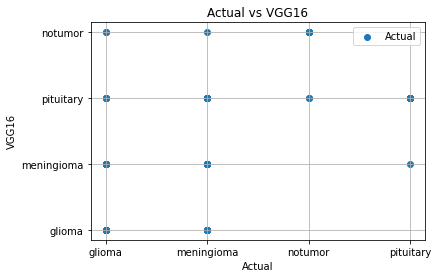

In [20]:
plt.scatter(model_predictions_train['actual'],model_predictions_train['vgg16'])
plt.title('Actual vs VGG16')
plt.xlabel('Actual')
plt.ylabel('VGG16')
plt.legend(['Actual', 'VGG16'])
plt.grid()

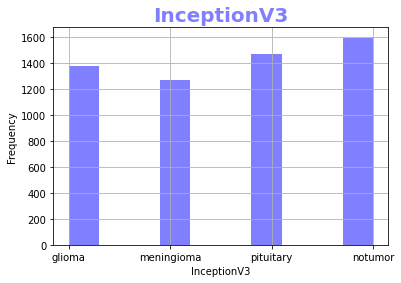

In [21]:
plt.hist(model_predictions_train['inception'],bins=10, stacked=True, color='blue', alpha=0.5)
plt.title('InceptionV3', fontsize=20, fontweight='bold', color='blue', alpha=0.5)
plt.xlabel('InceptionV3')
plt.ylabel('Frequency')
plt.grid()

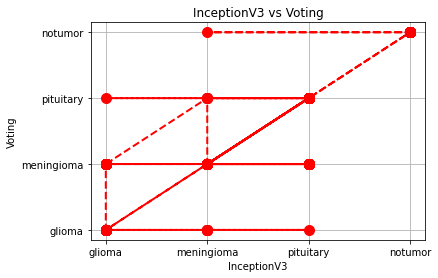

In [25]:
plt.plot(model_predictions_train['inception'],model_predictions_train['predicted_Voting'],c='r', marker='o', linestyle='dashed', linewidth=2, markersize=10)
plt.title('InceptionV3 vs Voting')
plt.xlabel('InceptionV3')
plt.ylabel('Voting')
plt.grid()

# Individual Model Accuracy


In [18]:
accuracy = pd.DataFrame(columns = ['train','test'], index = ['3c2f','vgg16','vgg16_ctrained','resnet','resnet_ctrained','inception','inception_ctrained']).fillna(0.0)

for i in accuracy.index.values:
    accuracy.loc[i,'train'] = round(accuracy_score(model_predictions_train['actual'], model_predictions_train[i])*100,2)
    
for i in accuracy.index.values:
    accuracy.loc[i,'test'] = round(accuracy_score(model_predictions_test['actual'], model_predictions_test[i])*100,2)
    
print(accuracy)

                    train   test
3c2f                94.87  91.84
vgg16               98.81  97.33
vgg16_ctrained      99.42  97.48
resnet              98.91  97.48
resnet_ctrained     99.46  98.40
inception           98.28  96.34
inception_ctrained  98.28  97.33


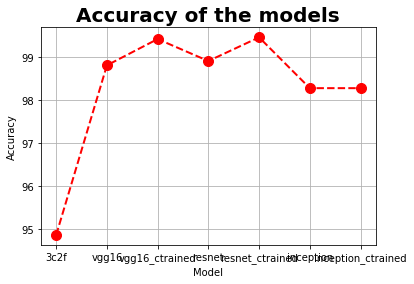

In [23]:

plt.plot(accuracy['train'],c='r', marker='o', linestyle='dashed', linewidth=2, markersize=10)
plt.title('Accuracy of the models', fontsize=20, fontweight='bold')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.grid()

# Boyer-Moore voting

In [26]:
def voting_predict(df):
    
    df['predicted_Voting'] = 'notumor'
    
    for i in df.index.values:
        if i != 'actual':
        
            classes_dict = {'glioma': 0,'meningioma':0,'notumor':0,'pituitary':0}
        
            models = df.columns.values
            for j in models:
                classes_dict[df.loc[i,j]] = classes_dict[df.loc[i,j]]+1 
        
            df.loc[i,'predicted_Voting'] = max(classes_dict.items(), key=operator.itemgetter(1))[0]
    
    return df

In [27]:
emsemble_train_predict = voting_predict(model_predictions_train)
emsemble_test_predict = voting_predict(model_predictions_test)

In [28]:
print('Train Accuracy is ', round(accuracy_score(emsemble_train_predict['actual'], emsemble_train_predict['predicted_Voting'])*100,2)) 
print('Test Accuracy is ', round(accuracy_score(emsemble_test_predict['actual'], emsemble_test_predict['predicted_Voting'])*100,2))

Train Accuracy is  99.89
Test Accuracy is  99.16


# Confusion Matrix for Voting

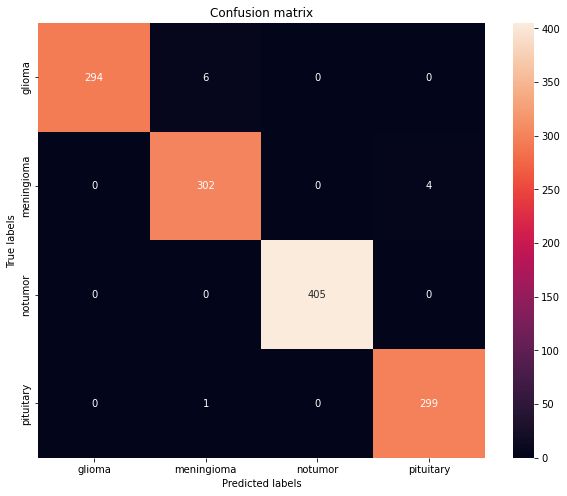

In [32]:
plt.figure(figsize=(10,8))
ax=plt.subplot()
cm= confusion_matrix(emsemble_test_predict['actual'], emsemble_test_predict['predicted_Voting'])
sns.heatmap(cm, annot=True, ax=ax, fmt='g')

# Label the plot, title, and show the plot and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');ax.set_title('Confusion matrix');
ax.xaxis.set_ticklabels(['glioma','meningioma','notumor','pituitary']);ax.yaxis.set_ticklabels(['glioma','meningioma','notumor','pituitary']);
#save the plot
plt.savefig('confusion_matrix_voting.png')

In [33]:
# Incorectly predicted test cases.
emsemble_test_predict[emsemble_test_predict['actual']!=emsemble_test_predict['predicted_Voting']]

,3c2f,vgg16,vgg16_ctrained,resnet,resnet_ctrained,inception,inception_ctrained,actual,predicted_Voting
Testing/glioma/Te-gl_0232.jpg,meningioma,meningioma,meningioma,meningioma,meningioma,glioma,glioma,glioma,meningioma
Testing/glioma/Te-gl_0237.jpg,meningioma,meningioma,meningioma,meningioma,glioma,glioma,meningioma,glioma,meningioma
Testing/glioma/Te-gl_0255.jpg,meningioma,meningioma,meningioma,glioma,glioma,meningioma,meningioma,glioma,meningioma
Testing/glioma/Te-gl_0265.jpg,meningioma,meningioma,meningioma,meningioma,glioma,meningioma,meningioma,glioma,meningioma
Testing/glioma/Te-gl_0276.jpg,meningioma,meningioma,meningioma,meningioma,meningioma,glioma,meningioma,glioma,meningioma
Testing/glioma/Te-gl_0277.jpg,meningioma,meningioma,glioma,meningioma,meningioma,meningioma,glioma,glioma,meningioma
Testing/meningioma/Te-meTr_0002.jpg,notumor,pituitary,pituitary,pituitary,pituitary,meningioma,meningioma,meningioma,pituitary
Testing/meningioma/Te-me_0140.jpg,notumor,pituitary,pituitary,pituitary,pituitary,meningioma,meningioma,meningioma,pituitary
Testing/meningioma/Te-me_0287.jpg,pituitary,pituitary,meningioma,pituitary,pituitary,pituitary,pituitary,meningioma,pituitary
Testing/meningioma/Te-me_0292.jpg,pituitary,meningioma,meningioma,pituitary,pituitary,pituitary,pituitary,meningioma,pituitary


# Random Forest


In [34]:
X = model_predictions_train[['3c2f','vgg16','vgg16_ctrained','resnet','resnet_ctrained','inception','inception_ctrained']]
y = model_predictions_train['actual']

X_val = model_predictions_test[['3c2f','vgg16','vgg16_ctrained','resnet','resnet_ctrained','inception','inception_ctrained']]
y_val = model_predictions_test['actual']

X = pd.get_dummies(X)
X_val = pd.get_dummies(X_val)

model = RandomForestClassifier(random_state=7)
model.fit(X,y)

prediction_train = model.predict(X)
prediction_val = model.predict(X_val)

print('Train Accuracy is ', round(accuracy_score(y, prediction_train)*100,2))
print('Test Accuracy is ', round(accuracy_score(y_val, prediction_val)*100,2))

Train Accuracy is  99.96
Test Accuracy is  98.93


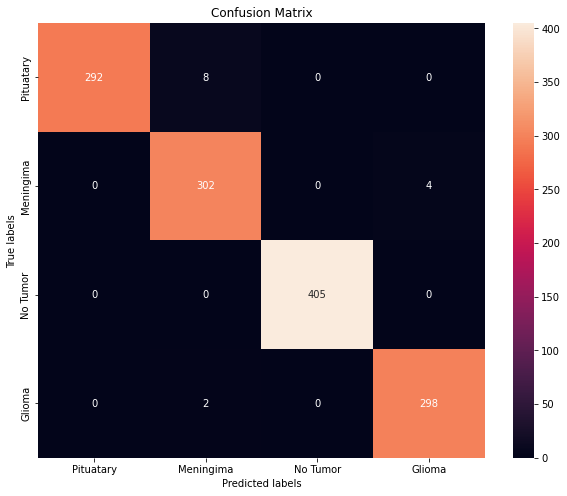

In [35]:
plt.figure(figsize=(10, 8))
ax= plt.subplot()
cm = confusion_matrix(model_predictions_test['actual'], prediction_val)
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Pituatary','Meningima','No Tumor','Glioma']); ax.yaxis.set_ticklabels(['Pituatary','Meningima','No Tumor','Glioma']);
#save the plot
plt.savefig('condusion_matrix_randomforest.png')

# XG Boost

In [46]:
X = model_predictions_train[['3c2f','vgg16','vgg16_ctrained','resnet','resnet_ctrained','inception','inception_ctrained']]
y = model_predictions_train['actual']

X_val = model_predictions_test[['3c2f','vgg16','vgg16_ctrained','resnet','resnet_ctrained','inception','inception_ctrained']]
y_val = model_predictions_test['actual']

X = pd.get_dummies(X)
X_val = pd.get_dummies(X_val)

# from sklearn.datasets import make_multilabel_classification
# X, y = make_multilabel_classification(n_features=4, random_state=7,n_classes=4)
# X_val, y_val = make_multilabel_classification(n_features=4, random_state=7,n_classes=4)

#label encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
y_val = le.fit_transform(y_val)

model = XGBClassifier(learning_rate=0.2, max_depth=4,seed=7,eval_metric = 'mlogloss')
model.fit(X,y)

prediction_train = model.predict(X)
prediction_val = model.predict(X_val)

print('Train Accuracy is ', round(accuracy_score(y, prediction_train)*100,2))
print('Test Accuracy is ', round(accuracy_score(y_val, prediction_val)*100,2))

Train Accuracy is  99.96
Test Accuracy is  99.01


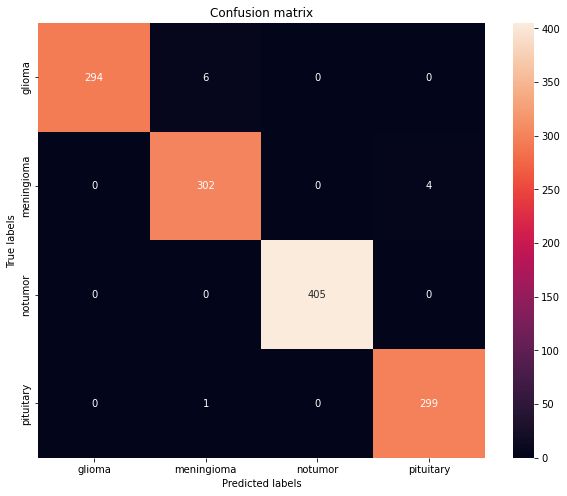

In [47]:
plt.figure(figsize=(10,8))
ax=plt.subplot()
cm= confusion_matrix(emsemble_test_predict['actual'], emsemble_test_predict['predicted_Voting'])
sns.heatmap(cm, annot=True, ax=ax, fmt='g')

# Label the plot, title, and show the plot and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');ax.set_title('Confusion matrix');
ax.xaxis.set_ticklabels(['glioma','meningioma','notumor','pituitary']);ax.yaxis.set_ticklabels(['glioma','meningioma','notumor','pituitary']);
#save the plot
plt.savefig('confusion_matrix_xgb.png')